# Outliers

An outlier is a data point that is significantly different from the remaining data.

"An outlier is an observation that deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism."
Outliers either deserve special attention or should be ignored. 
If outliers are, however, introduced by mechanical or measurement error, it is a good idea to remove these outliers before training the model. Why? because some algorithms are sensitive to outliers. 

## Machine learning models and outliers

Some machine learning models are sensitive to outliers. For instance, AdaBoost may treat outliers as "hard" cases and put tremendous weights on them, thus producing a model with poor generalisation.

Linear models, in particular linear regression, can also be sensitive to outliers.

Decision trees-based models are robust to outliers. Decision trees make decisions by asking if variable x is >= than a certain value, and therefore the outlier will fall on each side of the equation, but it will be treated similarly to non-outlier values.

## Identifying outliers

Outlier analysis and anomaly detection is a huge field of research devoted to optimising methods and creating new algorithms to reliably identify outliers. There are plenty of ways to detect outliers in different situations. These are mostly targeted to identify outliers when those are the observations that we want to focus on, for example, fraudulent credit card activity.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import scipy.stats as stats

# dataset for the demo
from sklearn.datasets import fetch_california_housing

In [2]:
# load the California House price data from Scikit-learn
X, Y = fetch_california_housing(return_X_y=True, as_frame=True)

# Remove lat and lon
X.drop(["Latitude", "Longitude"], axis=1, inplace=True)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467


In [3]:
# I will transform the variables for the demo.

X['MedInc'] = np.log(X['MedInc'])
X["AveRooms"] = 1 / X["AveRooms"]
X["AveBedrms"] = 1 / X["AveBedrms"]
X["AveOccup"] = 1 / X["AveOccup"]
X['Population'] = np.log(X['Population'])

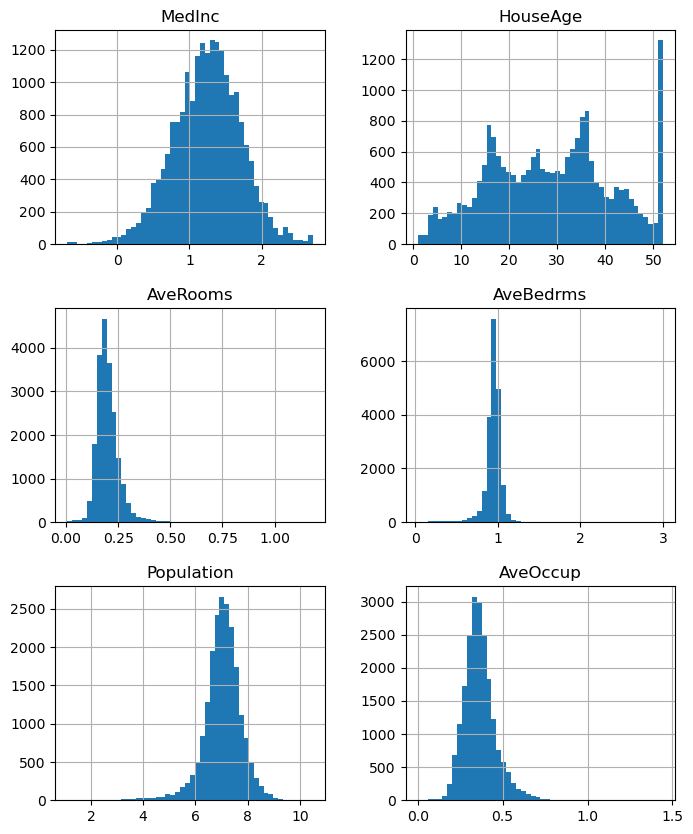

In [4]:
# Plot variable distributions:

X.hist(bins=50, figsize=(8, 10))
plt.show()

## Variable distribution

In normally distributed variables, outliers are those values that lie beyond the mean, plus or minus 3 times the standard deviation. If the variables are skewed, however, we find outliers using the inter-quantile range. In order to decide which method to use to detect outliers, we first need to know the distribution of the variable.

We can use histograms and Q-Q plots to determine if the variable is normally distributed. We can also use boxplots to directly visualise the outliers. Boxplots are a standard way of displaying the distribution of a variable, utilising the first quartile, the median, the third quartile, and the whiskers.

Looking at a boxplot, you can easily identify:

- The median, indicated by the line within the box.

- The inter-quantile range (IQR), the box itself.

- The quantiles, the 25th (Q1) is the lower and the 75th (Q3) the upper end of the box.

- The wiskers, which extend to: 

  -- top whisker: Q3 + 1.5 x IQR

  -- bottom whisker: Q1 -1.5 x IQR

Any value sitting outside the whiskers is considered an outlier. 

Let's look at some examples below.

In [5]:
# Function to create a histogram, a Q-Q plot and
# a boxplot.


def diagnostic_plots(df, variable):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

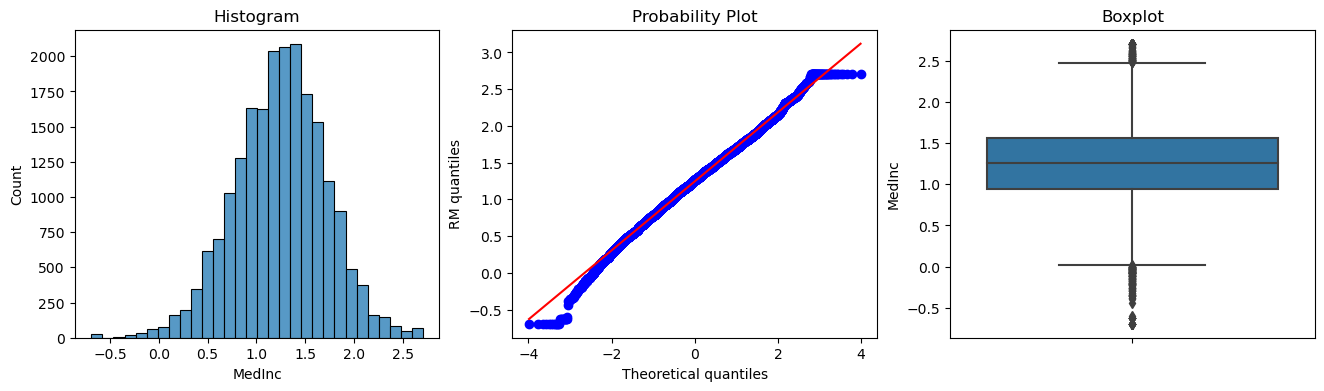

In [6]:
# Let's plot some of the variables

diagnostic_plots(X, 'MedInc')

From the histogram and the Q-Q plot, we see that the variable Median income shows roughly a normal distribution. The values deviate from the expected distribution towards the extremes. 

In the boxplot, we see some outliers, that is, the dots outside of the whiskers at both sides of the distribution.

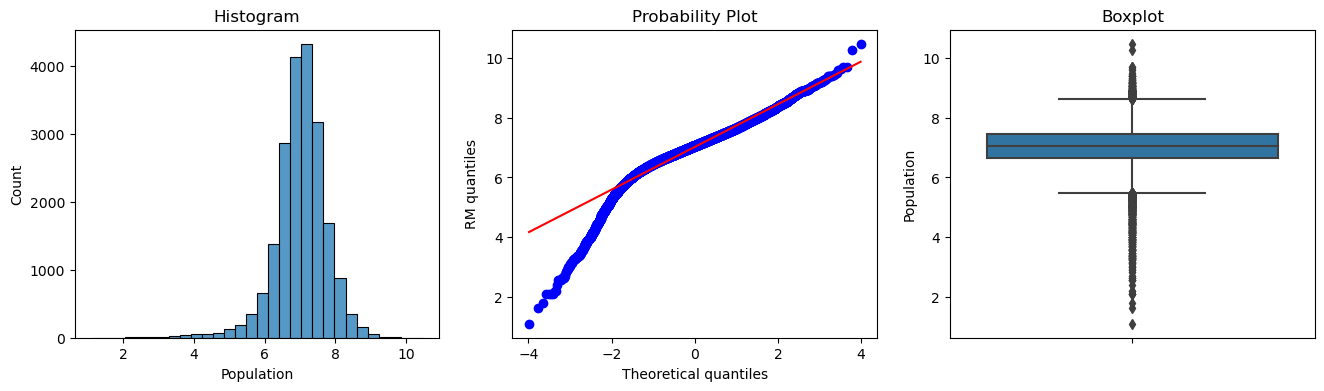

In [7]:
diagnostic_plots(X, 'Population')

Population is not normally distributed, and it shows outliers according to the Box-plot.

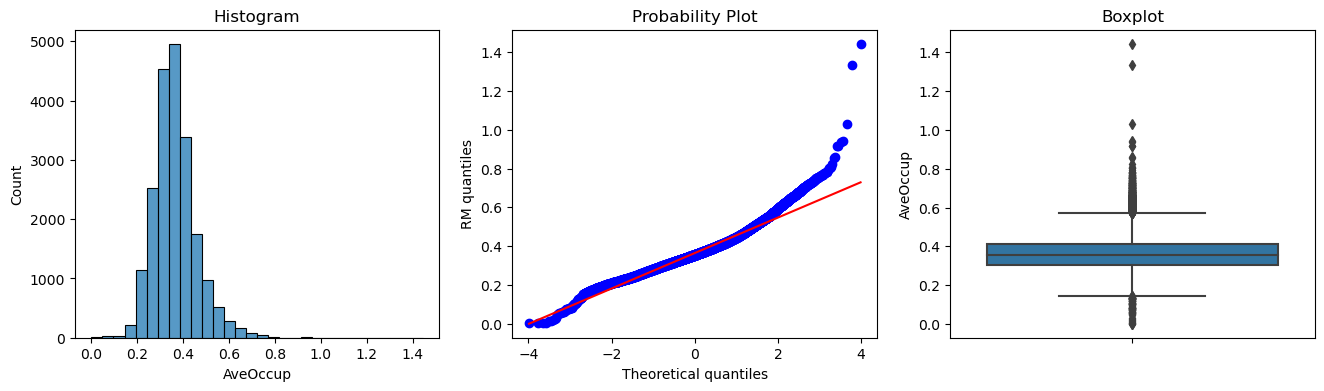

In [8]:
diagnostic_plots(X, 'AveOccup')

Average house occupancy is not normally distributed, and it shows outliers according to the Box-plot.



## Outlier detection

### Normally distributed variables

In [9]:
# Function to find upper and lower boundaries
# for normally distributed variables.

def find_normal_boundaries(df, variable):

    # Calculate the boundaries
    # for a Gaussian distribution.

    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [10]:
# Assuming that MedInc is normally distributed, 
# calculate boundaries for MedInc.

upper_boundary, lower_boundary = find_normal_boundaries(X, 'MedInc')
upper_boundary, lower_boundary

(2.656424304280744, -0.1674942963616315)

Values bigger than 2.35 or smaller than -0.16 occur very rarely in MedInc. Therefore, we can consider them outliers.

In [11]:
# Inspect the number and percentage of outliers in MedInc.

print('total number of houses: {}'.format(len(X)))

print('houses with right end outliers: {}'.format(
    len(X[X['MedInc'] > upper_boundary])))

print('houses with left end outliers: {}'.format(
    len(X[X['MedInc'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(X[X['MedInc'] > upper_boundary]) / len(X)))

print('% left end outliers: {}'.format(
    len(X[X['MedInc'] < lower_boundary]) / len(X)))

total number of houses: 20640
houses with right end outliers: 57
houses with left end outliers: 72

% right end outliers: 0.002761627906976744
% left end outliers: 0.0034883720930232558


Using Extreme Value Analysis we identified outliers at both ends of the distribution of MedInc. The percentage of outliers is small.

### Skewed variables

In [12]:
# Function to find upper and lower boundaries
# for skewed variables.


def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries
    # for skewed distributions

    # The parameter "distance" gives us the option to
    # estimate 1.5 times or 3 times the IQR when defining
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [13]:
# Find outliers with the IQR proximity rule.
# Here we use, IQR * 1.5, the standard metric.

upper_boundary, lower_boundary = find_skewed_boundaries(X, 'Population', 1.5)
upper_boundary, lower_boundary

(8.630113451037545, 5.491097126845318)

In [14]:
# Inspect the number and percentage of outliers in Population.

print('total number of houses: {}'.format(len(X)))

print('houses with right end outliers: {}'.format(
    len(X[X['Population'] > upper_boundary])))

print('houses with left end outliers: {}'.format(
    len(X[X['Population'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(X[X['Population'] > upper_boundary]) / len(X)))

print('% left end outliers: {}'.format(
    len(X[X['Population'] < lower_boundary]) / len(X)))

total number of houses: 20640
houses with right end outliers: 230
houses with left end outliers: 617

% right end outliers: 0.011143410852713179
% left end outliers: 0.029893410852713177
